<a id="top"></a>
# Exploratory Data Analysis
*** 
This notebook contains exploratory data analysis (EDA), ngrams, word clouds, timeseries plots and a brief analysis for HR. Click on any of the words or phrases in blue below to jump to that section.  

**Note : Plotting some images may restart a kernel, try with bigger environment if that happens (8vCPU and 16GB RAM works perfectly)**
   
More detail can be found in each section.

1. [Load Data/Preliminary EDA](#Load_Data/Preliminary_EDA)  
    * Load data from Data Assets section of the project
    * Conduct basic exploratory data analysis (shape, columns, etc.)
    
    
2. [ngrams (preliminary)](#ngrams_(preliminary)) 
    * Clean "text" data by removing stopwords and punctuation 
    * Create bi-grams and tri-grams for several groupings of the text and plot in chart
    * Run 4-grams to determine if output provides actionable value
    
        
3. [Word Clouds (preliminary)](#Word_Clouds_(preliminary)) 
    * Using the same groupings of text as created for ngrams above, we will create word clouds 
    
    
4. [Time Series Analysis](#time_series_analysis) 
    * Use the google analytics data(shared by MSK) to plot time series charts and analyze insights 
    
    
5. [Additional EDA](#Additional_EDA) 
    * This section provides a deeper dive into word patterns by leveraging MSK-provided data
    * URL paths (from MSK Google Analytics data) were mapped to a specific tile on the MSK Benefits website
    * Watson Discovery scraped text data was then grouped according to tile
    * [bi-grams](#bigrams), [tri-grams](#trigrams), [word clouds](#word_clouds), [keywords](#keywords), and [data for HR](#data_for_HR) are generated by tile
      

<div class="alert-warning">   
   
<font size="3"><b>*Please note*</b>: The first code block below assumes you have a CSV file of Watson Discovery scraped data available under the **Data Assets** section of your project. 
    
If you do not have scraped data available to import as a CSV, please go to the notebook titled **1_WatsonDiscovery_Crawl_and_Clean.ipynb** and run the respective code.</font>  
    

</div>

<a id="Load_Data/Preliminary_EDA"></a>
## 1. Load Data

Load the Watson Discovery crawled data from the MSK Benefits website and import all necessary libraries to run EDA.

In [3]:
from project_lib import Project
project = Project.access()

# Fetch the file
WD_data = project.get_file("msk_benefits_500_crawled_CLEAN_data.csv")

# Read the CSV data file into a pandas DataFrame
WD_data.seek(0)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

df = pd.read_csv(WD_data)


## Preliminary EDA

- Review shape of data to see row and column size
- Look at the available columns of data
- Look at data sparsity by column

In [4]:
df.shape

(2921, 36)

In [5]:
df.columns

Index(['document_id', 'result_metadata', 'enriched_text', 'metadata',
       'extracted_metadata', 'html', 'text', 'title', 'document_passages',
       'width', 'provider_url', 'type', 'provider_name', 'version', 'height',
       'date', 'parent', 'menu_order', 'modified_gmt', 'author', 'link',
       'comment_status', 'content', 'featured_media', 'ping_status', 'guid',
       'modified', 'excerpt', 'date_gmt', 'slug', 'status', 'name', 'count',
       'taxonomy', 'description', 'template'],
      dtype='object')

### Count of null values in each column

In [6]:
df.isnull().sum()

document_id             38
result_metadata       2301
enriched_text         2489
metadata              2460
extracted_metadata    2505
html                  2584
text                  2604
title                 2601
document_passages     2550
width                 2895
provider_url          2897
type                  2888
provider_name         2897
version               2897
height                2897
date                  2908
parent                2904
menu_order            2908
modified_gmt          2908
author                2908
link                  2904
comment_status        2908
content               2908
featured_media        2908
ping_status           2908
guid                  2908
modified              2910
excerpt               2910
date_gmt              2910
slug                  2906
status                2910
name                  2915
count                 2915
taxonomy              2915
description           2918
template              2918
dtype: int64

### Frequency of occurence of different types of titles in the crawled webpages

In [7]:
df['title'].value_counts().head()

Documents & Forms - MSK Benefits    17
MSK Benefits                        13
HSA vs. Health Care FSA              4
HSA Overview - MSK Benefits          4
New Hires ‚Äì MSK Benefits           4
Name: title, dtype: int64

[Back to top](#top)

<a id="ngrams_(preliminary)"></a>
## 2. ngrams (preliminary)

ngrams will be created using the 'text' field and follow the below steps. The standard practice when creating ngrams is to remove stopwords and all punctutation. Sometimes, especially when working with domain-specific terminology, it can be necessary to retain stopwords and some punctuation. For that reason, multiple columns will be created (with/without stopwords, with/without punctuation) so that the correct clean-up can be determined. 

- De-dupe 'text' field; if duplicates are not removed, ngram metrics will be artificially inflated
- Import libraries (regex and NLTK)
- Create several new columns which will be tested (with and without stopwords, with and without punctutation). We want to see the difference in ngrams between No Stopwords and With Stopwords; the additional columns will provide flexibility during EDA.
- Tokenize each column
- Create a bigram and trigram function
- Run each column through the function
- Print top 30 ngrams and plot the top 20 ngrams for each column
- At the very end of the ngram section, try 4-grams to assess the usefulness

### Drop duplicate text fields

In [8]:
df_text = df.drop_duplicates(subset=['text'])
print(df_text.shape)

(215, 36)


### Import regex, counter, nltk

In [9]:
import re
from itertools import chain
from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize 
from nltk.util import ngrams

[nltk_data] Downloading package stopwords to /home/wsuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/wsuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Remove stopwords and punctuation

In [10]:
stop_words = stopwords.words('english')

#convert text to str
df_text['text'] = df_text['text'].astype(str)

#remove stopwords
df_text['text_NSW'] = df_text['text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))

#remove punctuation
df_text['text_noPunc'] = df_text['text'].map(lambda x: re.sub(r'[^\'a-zA-Z0-9]', ' ', x))
df_text['text_NSW_noPunc'] = df_text['text_NSW'].map(lambda x: re.sub(r'[^\'a-zA-Z0-9]', ' ', x))


### Tokenize columns

In [11]:
df_text['textT'] = df_text['text'].apply(word_tokenize) 
df_text['text_NSWT'] = df_text['text_NSW'].apply(word_tokenize)
df_text['text_noPuncT'] = df_text['text_noPunc'].apply(word_tokenize) 
df_text['text_NSW_noPuncT'] = df_text['text_NSW_noPunc'].apply(word_tokenize)

### Create bi-gram function

In [12]:
def _bigram(text):
    
    return list(nltk.bigrams(text))         

### Run columns through bigram function

In [13]:
df_text['text_bigrams'] = df_text.apply(lambda row: _bigram(row['textT']), axis=1) 
df_text['textNSW_bigrams'] = df_text.apply(lambda row: _bigram(row['text_NSWT']), axis=1)
df_text['text_noPunc_bigrams'] = df_text.apply(lambda row: _bigram(row['text_noPuncT']), axis=1) 
df_text['text_NSW_noPunc_bigrams'] = df_text.apply(lambda row: _bigram(row['text_NSW_noPuncT']), axis=1) 

### Review and plot bigrams

First, look at the top 30 bigrams and plot the top 20 bigrams. We can see in the results that punctuation and some non-words ('nbsp', 'amp') appear. Also note the presence of stopwords. 

Sometimes it's necessary to keep stopwords during EDA because they provide context and meaning. In this case, it looks like the stopwords can be removed without losing any value.

#### Bigrams with stopwords and punctuation

[(('&', 'nbsp'), 491), (('nbsp', ';'), 491), ((',', 'and'), 375), ((',', 'you'), 358), (('.', 'You'), 290), (('of', 'the'), 277), (('.', 'If'), 266), (('If', 'you'), 240), (('in', 'the'), 230), (('You', 'can'), 215), (("'", ']'), 185), (('[', "'"), 173), (('on', 'the'), 166), (('you', 'can'), 163), (('.', "'"), 161), ((',', 'or'), 160), (('of', 'your'), 159), (('to', 'the'), 156), (('will', 'be'), 154), ((')', '.'), 148), (('.', 'The'), 143), (('to', 'your'), 143), (('if', 'you'), 143), (('you', 'have'), 134), (('you', 'will'), 117), (('medical', 'plan'), 117), (('for', 'the'), 109), (('up', 'to'), 104), (('&', 'amp'), 104), (('amp', ';'), 104)]


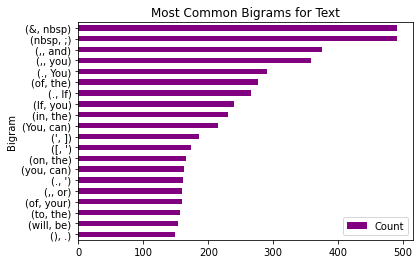

In [14]:
bigrams = df_text['text_bigrams'].tolist()
bigrams = list(chain(*bigrams))
bigram_counts = Counter(bigrams)
print(bigram_counts.most_common(30))

#plot top 20 bigrams
a = bigram_counts.most_common(20)

bigram_plot = pd.DataFrame(a, columns =['Bigram', 'Count'])
bigram_plot = bigram_plot.sort_values(by = 'Count')

bigram_plot.plot(x = 'Bigram',y=['Count'], kind='barh', color='purple')
plt.title("Most Common Bigrams for Text")
plt.show()

#### Bigrams with punctuation, no stopwords

In [15]:
bigrams1 = df_text['textNSW_bigrams'].tolist()
bigrams1 = list(chain(*bigrams1))
bigram_counts1 = Counter(bigrams1)
print(bigram_counts.most_common(30))

#plot top 20 bigrams
b = bigram_counts1.most_common(20)

bigram_plot1 = pd.DataFrame(b, columns =['Bigram', 'Count'])
bigram_plot1 = bigram_plot1.sort_values(by = 'Count')

bigram_plot1.plot(x = 'Bigram',y=['Count'], kind='barh', color='blue')
plt.title("Most Common Bigrams for Text No Stopwords")
plt.show()

[(('&', 'nbsp'), 491), (('nbsp', ';'), 491), ((',', 'and'), 375), ((',', 'you'), 358), (('.', 'You'), 290), (('of', 'the'), 277), (('.', 'If'), 266), (('If', 'you'), 240), (('in', 'the'), 230), (('You', 'can'), 215), (("'", ']'), 185), (('[', "'"), 173), (('on', 'the'), 166), (('you', 'can'), 163), (('.', "'"), 161), ((',', 'or'), 160), (('of', 'your'), 159), (('to', 'the'), 156), (('will', 'be'), 154), ((')', '.'), 148), (('.', 'The'), 143), (('to', 'your'), 143), (('if', 'you'), 143), (('you', 'have'), 134), (('you', 'will'), 117), (('medical', 'plan'), 117), (('for', 'the'), 109), (('up', 'to'), 104), (('&', 'amp'), 104), (('amp', ';'), 104)]


### Remove 'nbsp'

In the above chart, a text pattern 'nbsp' appears with frequency. In the following code block, we will remove this non-word from the two "no punctuation" columns before creating bigrams.

In [16]:
df_text['text_noPunc'] = df_text['text_noPunc'].map(lambda x: re.sub(r'^nbsp', ' ', x))
df_text['text_NSW_noPunc'] = df_text['text_NSW_noPunc'].map(lambda x: re.sub(r'^nbsp', ' ', x))

### Re-tokenize columns

In [17]:
# It's necessary to re-tokenize the two columns being used for ngrams: text with no punctuation and text with no punctuation/no stopwords.
df_text['text_noPuncT'] = df_text['text_noPunc'].apply(word_tokenize) 
df_text['text_NSW_noPuncT'] = df_text['text_NSW_noPunc'].apply(word_tokenize)

### Re-run bigram function

In [18]:
# Re-run bigram function on updated columns
df_text['text_noPunc_bigrams'] = df_text.apply(lambda row: _bigram(row['text_noPuncT']), axis=1) 
df_text['text_NSW_noPunc_bigrams'] = df_text.apply(lambda row: _bigram(row['text_NSW_noPuncT']), axis=1) 

#### Bigrams with stopwords, no punctuation 

In [19]:
bigrams2 = df_text['text_noPunc_bigrams'].tolist()
bigrams2 = list(chain(*bigrams2))
bigram_counts2 = Counter(bigrams2)
print(bigram_counts2.most_common(30))

#plot top 20 bigrams
c = bigram_counts2.most_common(20)

bigram_plot2 = pd.DataFrame(c, columns =['Bigram', 'Count'])
bigram_plot2 = bigram_plot2.sort_values(by = 'Count')

bigram_plot2.plot(x = 'Bigram',y=['Count'], kind='barh', color='green')
plt.title("Most Common Bigrams for Text No Punctuation")
plt.show()

[(('If', 'you'), 311), (('of', 'the'), 277), (('in', 'the'), 235), (('You', 'can'), 223), (('you', 'can'), 170), (('on', 'the'), 166), (('if', 'you'), 165), (('of', 'your'), 159), (('to', 'the'), 156), (('will', 'be'), 154), (('to', 'your'), 144), (('you', 'have'), 134), (('you', 're'), 133), (('medical', 'plan'), 119), (('you', 'will'), 117), (('for', 'the'), 112), (('up', 'to'), 109), (('access', 'to'), 101), (('help', 'you'), 97), (('you', 'are'), 97), (('to', 'you'), 97), (('on', 'your'), 93), (('enrolled', 'in'), 93), (('eligible', 'for'), 89), (('Open', 'Enrollment'), 89), (('HealthEquity', 'WageWorks'), 89), (('you', 'll'), 88), (('need', 'to'), 86), (('for', 'a'), 86), (('out', 'of'), 85)]


#### Bigrams with no punctuation and no stopwords

[(('you', 're'), 133), (('medical', 'plan'), 119), (('HealthEquity', 'WageWorks'), 90), (('Open', 'Enrollment'), 89), (('you', 'll'), 88), (('the', 'nbsp'), 75), (('MSK', 'medical'), 73), (('If', 'you'), 71), (('You', 'also'), 70), (('in', 'network'), 70), (('Want', 'Know'), 67), (('Know', 'More'), 67), (('out', 'of'), 65), (('Health', 'Care'), 64), (('Resource', 'Center'), 51), (('Care', 'FSA'), 51), (('HR', 'Resource'), 48), (('You', 'may'), 48), (('Flexible', 'Spending'), 47), (('Spending', 'Account'), 47), (('Term', 'Disability'), 47), (('For', 'information'), 46), (('domestic', 'partner'), 46), (('ID', 'cards'), 46), (('Express', 'Scripts'), 45), (('change', 'status'), 45), (('covered', 'dependents'), 45), (('Out', 'of'), 43), (('Savings', 'Solutions'), 43), (('Health', 'Savings'), 42)]


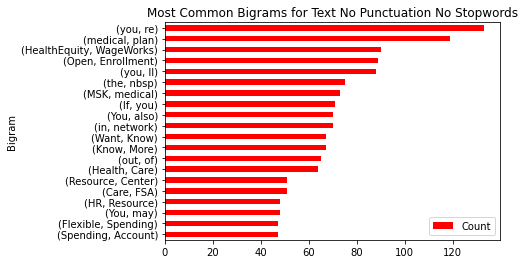

In [20]:
bigrams3 = df_text['text_NSW_noPunc_bigrams'].tolist()
bigrams3 = list(chain(*bigrams3))
bigram_counts3 = Counter(bigrams3)
print(bigram_counts3.most_common(30))

#plot top 20 bigrams
d = bigram_counts3.most_common(20)

bigram_plot3 = pd.DataFrame(d, columns =['Bigram', 'Count'])
bigram_plot3 = bigram_plot3.sort_values(by = 'Count')

bigram_plot3.plot(x = 'Bigram',y=['Count'], kind='barh', color='red')
plt.title("Most Common Bigrams for Text No Punctuation No Stopwords")
plt.show()

### Create tri-gram function

In [21]:
def _trigram(text):

    return list(nltk.trigrams(text))
             

### Run trigram function only on text with no stopwords, no punctuation

In [22]:
# Because the text without punctuation and no stopwords results in useful output, the trigram function will only be run on this column

df_text['text_NSW_noPunc_trigrams'] = df_text.apply(lambda row: _trigram(row['text_NSW_noPuncT']), axis=1) 

### Review trigrams

#### Trigrams no stopwords, no punctuation

[(('Want', 'Know', 'More'), 67), (('If', 'you', 're'), 65), (('MSK', 'medical', 'plan'), 54), (('HR', 'Resource', 'Center'), 48), (('Rx', 'Savings', 'Solutions'), 42), (('Health', 'Savings', 'Account'), 40), (('change', 'status', 'event'), 39), (('out', 'of', 'pocket'), 38), (('Flexible', 'Spending', 'Account'), 35), (('Long', 'Term', 'Disability'), 32), (('Health', 'Care', 'FSA'), 32), (('Care', 'Flexible', 'Spending'), 31), (('enrolled', 'MSK', 'medical'), 30), (('Savings', 'Account', 'HSA'), 30), (('Documents', 'amp', 'Forms'), 29), (('Paid', 'Parental', 'Leave'), 29), (('646', '677', '7411'), 28), (('Know', 'More', 'Check'), 27), (('detailed', 'plan', 'information'), 27), (('out', 'of', 'network'), 27), (('hrrc', 'mskcc', 'org'), 26), (('You', 'also', 'find'), 26), (('amp', 'Forms', 'page'), 26), (('find', 'detailed', 'plan'), 25), (('plan', 'information', 'Documents'), 24), (('information', 'Documents', 'amp'), 24), (('spouse', 'domestic', 'partner'), 24), (('Social', 'Security', 

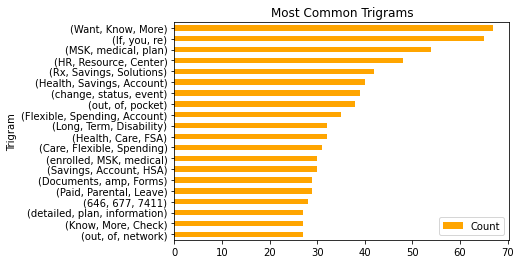

In [23]:
trigrams = df_text['text_NSW_noPunc_trigrams'].tolist()
trigrams = list(chain(*trigrams))

trigram_counts = Counter(trigrams)
print(trigram_counts.most_common(30))

t = trigram_counts.most_common(20)

trigram_plot = pd.DataFrame(t, columns =['Trigram', 'Count'])
trigram_plot = trigram_plot.sort_values(by = 'Count')

trigram_plot.plot(x = 'Trigram',y=['Count'], kind='barh', color=['orange'])
plt.title("Most Common Trigrams")
plt.show()

### 4-grams

While ngrams above trigrams aren't as common as bigrams and trigrams, we will create a 4-gram function and review the output because this is exploratory data analysis.

### Create 4-gram function

In [24]:
n = 4

def _4gram(text):
    
    return ngrams(text.split(), n)

### Run 4-gram function on text with no stopwords, no punctuation

In [25]:
df_text['text_NSW_noPunc_4grams'] = df_text.apply(lambda row: _4gram(row['text_NSW_noPunc']), axis=1) 

### Review 4-grams

#### 4-grams no stopwords, no punctuation

[(('enrolled', 'MSK', 'medical', 'plan'), 29), (('Health', 'Savings', 'Account', 'HSA'), 29), (('Want', 'Know', 'More', 'Check'), 27), (('Care', 'Flexible', 'Spending', 'Account'), 27), (('Documents', 'amp', 'Forms', 'page'), 26), (('find', 'detailed', 'plan', 'information'), 25), (('detailed', 'plan', 'information', 'Documents'), 24), (('plan', 'information', 'Documents', 'amp'), 24), (('information', 'Documents', 'amp', 'Forms'), 24), (('You', 'also', 'find', 'detailed'), 23), (('also', 'find', 'detailed', 'plan'), 23), (('contact', 'HR', 'Resource', 'Center'), 23), (('out', 'of', 'pocket', 'maximum'), 23), (('amp', 'Forms', 'page', "'"), 22), (('Want', 'Know', 'More', 'About'), 22), (('Know', 'More', 'About', 'Something'), 22), (('More', 'About', 'Something', 'Else'), 22), (('About', 'Something', 'Else', 'Check'), 22), (('Something', 'Else', 'Check', 'rest'), 22), (('Else', 'Check', 'rest', 'the'), 22), (('Check', 'rest', 'the', 'nbsp'), 22), (('rest', 'the', 'nbsp', 'Glossary'), 22

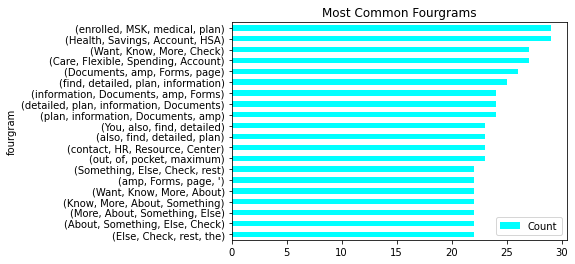

In [26]:
fourgrams = df_text['text_NSW_noPunc_4grams'].tolist()
fourgrams = list(chain(*fourgrams))

fourgram_counts = Counter(fourgrams)
print(fourgram_counts.most_common(30))

r = fourgram_counts.most_common(20)

fourgram_plot = pd.DataFrame(r, columns =['fourgram', 'Count'])
fourgram_plot = fourgram_plot.sort_values(by = 'Count')

fourgram_plot.plot(x = 'fourgram',y=['Count'], kind='barh', color=['aqua'])
plt.title("Most Common Fourgrams")
plt.show()

## ngram Summary

Based on the above exploration, some text clean-up is necessary and some punctuation (for contractions and phone numbers) should remain.

[Back to top](#top)

<a id="Word_Clouds_(preliminary)"></a>
## 3. Word Clouds (preliminary)

Word Clouds will be created based on subsets of the 'text' field. Since we are in the early stage of EDA, the 'Title' field will be used to create subsets for the 'text' field. Three different word clouds will be created based on the first three titles below. "Count" represents the number of web pages having the title.

Title,                                                    Count
- Documents & Forms - MSK Benefits                        17
- MSK Benefits                                            13
- HSA Overview - MSK Benefits                              4
- Preventive Care - MSK Benefits                           4
- New Hires – MSK Benefits                                 4
- HSA vs. Health Care FSA                                  4
- Lactation Rooms - MSK Benefits                           3
- Core Long-Term Disability Coverage – MSK Benefits        3
- Tobacco Cessation Program - MSK Benefits                 3
- Telemedicine - MSK Benefits                              3
- Commuter Spending Account - MSK Benefits                 3
- Retirement Tool – MSK Benefits                           3
- Vision Option - MSK Benefits                             3
- Dental Plan Comparisons - MSK Benefits                   3
- Time Away – MSK Benefits                                 3
- Retirement Savings Plan (RSP): 403(b)                    3


### Ensure 'title' and 'text' are strings

In [27]:
df_text['title'] = df_text['title'].astype(str)
df_text['text'] = df_text['text'].astype(str)

### Install Word Cloud libraries and colors for charts

In [28]:
!pip install WordCloud

from wordcloud import WordCloud 
from matplotlib import colors

     |████████████████████████████████| 366 kB 6.9 MB/s eta 0:00:01


### Word Cloud where Title field = Documents & Forms - MSK Benefits

In [29]:
words = ' '.join([text for text in df_text[df_text['title']=='Documents & Forms - MSK Benefits']['text']])
wordCloud = WordCloud(background_color='white', mode="RGB", width=2000 , height=1000).generate(words)
plt.figure(figsize=(20,10))
plt.imshow(wordCloud)
plt.show()

### Word Cloud where Title field = MSK Benefits

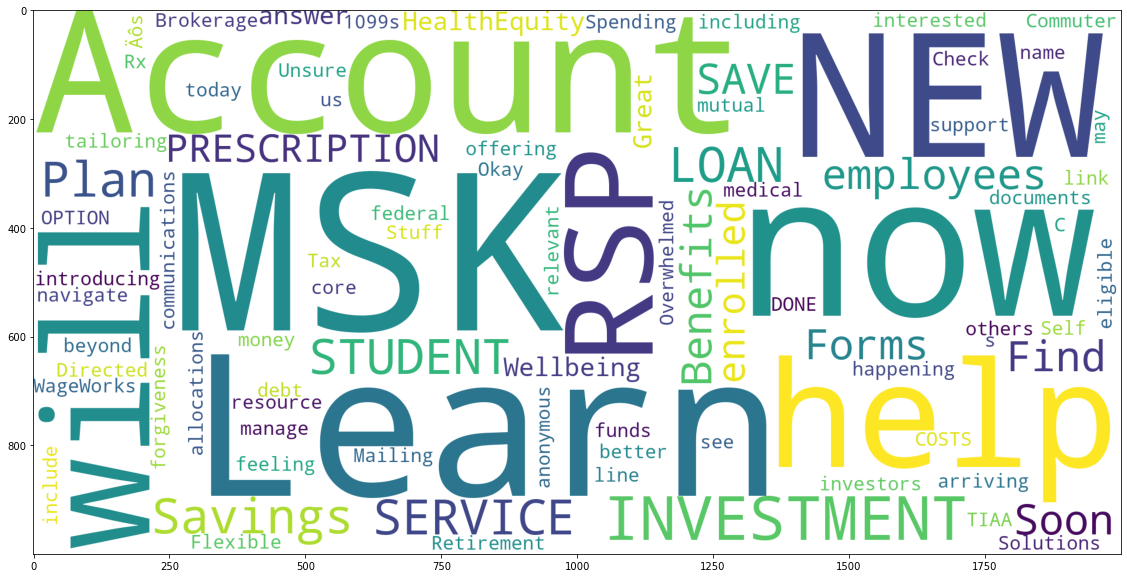

In [30]:
words1 = ' '.join([text for text in df_text[df_text['title']=='MSK Benefits']['text']])
wordCloud1 = WordCloud(background_color='white', mode="RGB", width=2000 , height=1000).generate(words1)
plt.figure(figsize=(20,10))
plt.imshow(wordCloud1)
plt.show()

### Word Cloud where Title field = HSA Overview - MSK Benefits

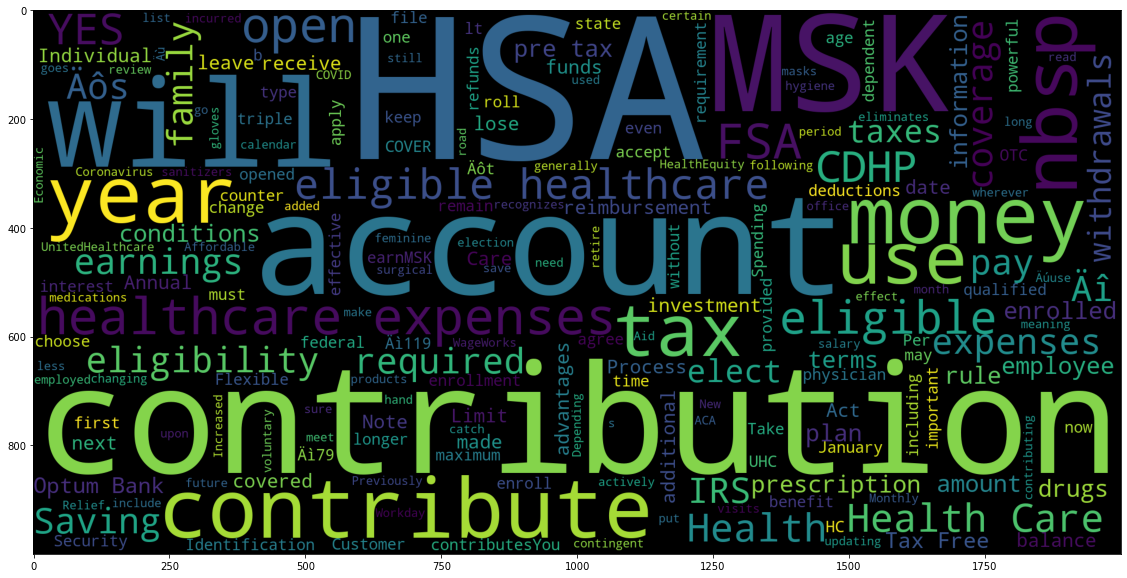

In [31]:
words2 = ' '.join([text for text in df_text[df_text['title']=='HSA Overview - MSK Benefits']['text']])
wordCloud2 = WordCloud(background_color='black', mode="RGB", width=2000 , height=1000).generate(words2)
plt.figure(figsize=(20,10))
plt.imshow(wordCloud2)
plt.show()

[Back to top](#top)

<a id="time_series_analysis"></a>
## 4. Time Series Analysis

The following section explores the time series analysis of the MSK benefits website google analytics data

### Load the MSK Benefits website google analytics page view data

In [32]:
df_page_views = pd.read_excel('/project_data/data_asset/2021_0701_MSKBenefits_Analytics Production_Pages_20200701_20210630.xlsx', sheet_name='Dataset2')
df_page_views.head()

Day Index  Pageviews
0 2020-07-01       2059
1 2020-07-02       1502
2 2020-07-03        897
3 2020-07-04        311
4 2020-07-05        535

In [33]:
df_page_views = df_page_views.iloc[0:364]

### Visualize Page views across the entire data 
Oct/Nov saw highest page visits – Due to benefits selection period for next year

In [34]:
# Using plotly.express
import plotly.express as px

fig = px.bar(df_page_views, x='Day Index', y="Pageviews")
fig.show()

### Create new column for day of week and month from the existing date data

In [35]:
df_page_views['dayofweek'] = pd.to_datetime(df_page_views['Day Index']).dt.day_name()
df_page_views['month'] = pd.to_datetime(df_page_views['Day Index']).dt.month_name()

### Sort data by month and Day Index

In [36]:
month_starter = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

df_page_views_sorted_month = df_page_views.sort_values(by=['month', 'Day Index'])
df_page_views_sorted_month.head()

Day Index  Pageviews dayofweek  month
274 2021-04-01       1583  Thursday  April
275 2021-04-02       1026    Friday  April
276 2021-04-03        325  Saturday  April
277 2021-04-04        419    Sunday  April
278 2021-04-05       1697    Monday  April

In [37]:
# Create the dictionary that defines the order for sorting
month_starter = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sorterIndex = dict(zip(month_starter, range(len(month_starter))))
df_page_views_sorted_month['mo'] = df_page_views['month'].map(sorterIndex)
df_page_views_sorted_month.sort_values(['mo', 'Day Index'], ascending = [True, True], inplace = True)
df_page_views_sorted_month.head()

Day Index  Pageviews dayofweek    month  mo
184 2021-01-01        425    Friday  January   0
185 2021-01-02        431  Saturday  January   0
186 2021-01-03        614    Sunday  January   0
187 2021-01-04       2870    Monday  January   0
188 2021-01-05       2188   Tuesday  January   0

### Visualize Page views across the entire data 
Oct/Nov saw highest page visits – Due to benefits selection period for next year

In [38]:
# Using plotly.express
import plotly.express as px

fig = px.bar(df_page_views_sorted_month, x='month', y="Pageviews", color='month')
fig.show()

In [39]:
day_sorter = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df_page_views_sorted_dow = df_page_views.sort_values(by=['dayofweek', 'Day Index'])
df_page_views_sorted_dow.head()

Day Index  Pageviews dayofweek month
2  2020-07-03        897    Friday  July
9  2020-07-10       1235    Friday  July
16 2020-07-17       1279    Friday  July
23 2020-07-24       1215    Friday  July
30 2020-07-31       1282    Friday  July

In [40]:
# Create the dictionary that defines the order for sorting
day_sorter = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
sorterIndex = dict(zip(day_sorter, range(len(day_sorter))))
df_page_views_sorted_dow['dow'] = df_page_views['dayofweek'].map(sorterIndex)
df_page_views_sorted_dow.sort_values(['dow', 'Day Index'], ascending = [True, True], inplace = True)

df_page_views_sorted_dow.head()

Day Index  Pageviews dayofweek   month  dow
4  2020-07-05        535    Sunday    July    0
11 2020-07-12        481    Sunday    July    0
18 2020-07-19        550    Sunday    July    0
25 2020-07-26        545    Sunday    July    0
32 2020-08-02        624    Sunday  August    0

### Visualize page views wrt day of week
Page visits is highest at the beginning of the week and wanes towards the end of the week

In [41]:
# Using plotly.express
import plotly.express as px

fig = px.line(df_page_views_sorted_dow, x='Day Index', y="Pageviews", color="dayofweek")
fig.show()

In [42]:
# Using plotly.express
import plotly.express as px

fig = px.bar(df_page_views_sorted_dow, x='dayofweek', y="Pageviews", color='dayofweek')
fig.show()

[Back to top](#top)

<a id="Additional_EDA"></a>
## 5. Additional EDA

The following section continues exploring the data above but takes it a step further. The web page URL is extracted from the Watson Discovery scraped json data in order to match the URLs with the MSK-provided URL path (which have been mapped to a tile). Dataframes will be constructed for the tiles and used for ngrams and word clouds. 

### Function to extract URLs from Watson Discovery data

In [43]:
def urlc(x):
    s = x.find("url': ")+7
    e = x.find("Date")-5
    return x[s:e]

### Run function and create new column

In [44]:
df_text['cleaned_url'] = df_text['metadata'].astype(str).apply(lambda x: urlc(x))

### Ensure function worked, convert column to string 

In [45]:
print(df_text.cleaned_url.head(3))

df_text.cleaned_url = df_text.cleaned_url.astype(str)

0    https://mskbenefits.mskcc.org/keyword/looking-...
1    https://mskbenefits.mskcc.org/keyword/adoption...
2    https://mskbenefits.mskcc.org/keyword/move-wel...
Name: cleaned_url, dtype: object


### Clean text field

Use the column for text created above where stopwords are removed. Remove all punctuation except hyphen and apostrophe. Create new column called 'text_clean2'.

In [46]:
df_text['text_clean2'] = df_text['text_NSW'].map(lambda x: re.sub(r'[^a-zA-Z0-9-\']', ' ', x))

### Assign MSK-provided URL paths to specific tile
These represent the URL from top100 google analytics pages

In [47]:
retire = ['/keyword/documents-forms-retirement/',
          '/keyword/403b/',
          '/keyword/pension/',
          '/keyword/pension-plan/',
          '/retirement-tool-landing/',
          '/retirement-tool/',
          '/keyword/pension-plan-faqs/',
          '/keyword/retiree-medical-plans/',
          '/keyword/retirement-guidance-support-tools/',
          '/keyword/403b/?childslug=403b&syn=403(b)&parentslug=retirement&parentname=Retirement',
          '/keyword/managing-your-rsp/',
          '/keyword/key-employee-supplemental-savings-plan-kessp-457b']


health = ['/keyword/documents-forms-medical-parent/',
          '/keyword/documents-forms/?childslug=documents-forms&syn=Documents+&+Forms=&parentslug=medical-parent&parentname=Medical',
          '/keyword/documents-forms-vision-parent/?childslug=documents-forms-vision-parent&syn=Documents+&+Forms=&parentslug=vision-parent&parentname=Vision',
          '/keyword/dental-documents-forms/?childslug=dental-documents-forms&syn=Documents+&+Forms=&parentslug=dental-parent&parentname=Dental',
          '/keyword/2020-medical-plan-overview/',
          '/keyword/see-a-healthcare-provider/',
          '/2021-medical-plan-modeler/',
          '/keyword/premiums/',
          '/2020-medical-plan-modeler/',
          '/keyword/2020-aetna-epo/',
          '/keyword/2020-uhc-cdhp/',
          '/keyword/2020-empire-pos/',
          '/keyword/dental-options-keyword/',
          '/category/medical/',
          '/keyword/2020-aetna-pos/',
          '/keyword/documents-forms/',
          '/keyword/vision-option-keyword/',
          '/keyword/2020-uhc-tiered-epo/',
          '/contacts/',
          '/keyword/check-your-providers/',
          '/keyword/medical-deductible/',
          '/keyword/dental-premiums-keyword/',
          '/keyword/im-enrolled-in-the-empire-pos/',
          '/category/dental/',
          '/keyword/im-enrolled-in-the-aetna-epo/',
          '/keyword/im-enrolled-in-the-aetna-pos/',
          '/keyword/dental-options-keyword/?childslug=dental-options-keyword&syn=Options&parentslug=dental-parent&parentname=Dental',
          '/keyword/workday-glossary/?childslug=workday-glossary&syn=Workday&parentslug=glossary-parent&parentname=Glossary?web=1',
          '/keyword/accidental-death-dismemberment-keyword/?childslug=accidental-death-dismemberment-keyword&syn=AD&D=&parentslug=life-disability-parent&parentname=Life+&+Disability=',
          '/keyword/life-insurance-keyword/?childslug=life-insurance-keyword&syn=Life+Insurance&parentslug=life-disability-parent&parentname=Life+&+Disability=',
          '/keyword/dental-plan-comparisons-keyword/?childslug=dental-plan-comparisons-keyword&syn=Plan+Comparison+Chart&parentslug=dental-parent&parentname=Dental',
          '/keyword/check-your-providers-metlife/?childslug=check-your-providers-metlife&syn=MetLife+Providers&parentslug=dental-parent&parentname=Dental']



savings = ['/keyword/commuter-keyword/?childslug=commuter-keyword&syn=Commuter+Spending+Account&parentslug=accounts-parent&parentname=Spending+Accounts]',
           '/keyword/save-money/',
           '/keyword/hsa-details/',
           '/keyword/employee-discounts/',
           '/keyword/rx-savings-solutions/',
           '/keyword/healthcare-fsa-keyword/',
           '/keyword/prescription-coverage-keyword/',
           '/keyword/dependent-fsa-keyword/?childslug=dependent-fsa-keyword&syn=Dependent+Care+FSA&parentslug=accounts-parent&parentname=Spending+Accounts',
           '/keyword/fitness-center-discounts/',
           '/keyword/employee-discounts/?childslug=employee-discounts&syn=Employee Discounts&parentslug=wellness-parent&parentname=Wellness?web=1',
          '/keyword/savi/']
           
           
new_hire = ['/keyword/open-enrollment-overview-2021/',
            '/new-hires/tour/',
            '/new-hires/home/',
            '/new-hires/facts/',
            '/new-hires/enrollment/',
            '/new-hires/next-steps/',
            '/keyword/2021-enrollment-tools-and-resources/',
            '/keyword/top-10-enrollment-questions/']   

change = [
    '/keyword/change-in-status-event/?childslug=change-in-status-event&syn=Change+in+Status+Event&parentslug=glossary-parent&parentname=Glossary',
    '/keyword/change-in-status-event/',
    '/keyword/change-in-status-event-documentation/?childslug=change-in-status-event-documentation&syn=Change+in+Status+Event+Documentation&parentslug=glossary-parent&parentname=Glossary',
    '/keyword/change-my-benefits-coverage/']

get_active = [
    '/category/wellness/',
    '/keyword/covid-19/',
    '/keyword/get-active/',
    '/keyword/be-well/',
    '/keyword/covid-19/?web=1',
    '/keyword/fertility-support-program/',
    '/keyword/health-advocate/']

take_leave = ['/keyword/metlife-leave-of-absence-glossary-2/',
              '/keyword/documents-forms-leaves/',
              '/loa-tool/',
              '/keyword/sick-and-disability/',
              '/leave-of-absence-page/',
              '/keyword/leave-of-absence-faqs/',
              '/keyword/long-term-disability-keyword/',
              '/keyword/short-term-disability-leaves/',
              '/keyword/ny-paid-family-leave/',
              '/other-type/returning-from-a-leave/?web=1',
              '/loa-results/?loa-leave-type=im-sickinjured-and-need-time-to-recover&loa-sick-injury-location=no&loa-tenure=12-months-or-more&loa-location=new-york&loa-time-away=more-than-7-days&action=pcloa_get_time_off_results',
              '/time-away/',
              '/keyword/sick-time/',
              '/keyword/msk-paid-parental-leave/',
              '/loa-results/?loa-leave-type=im-giving-birth&loa-birth-type=regular-delivery&loa-tenure=12-months-or-more&loa-location=new-york&action=pcloa_get_time_off_results',
              '/keyword/vacation-and-holidays/',
              '/keyword/take-time-off/',
              '/keyword/hr-resource-center/?childslug=hr-resource-center&syn=HRRC&parentslug=leaves&parentname=Leaves?web=1']

cancer = ['/keyword/facing-a-cancer-diagnosis/']

child = ['/keyword/welcoming-a-new-child/'] 

child_care = ['/keyword/looking-for-child-care/']

relationship = ['/keyword/change-in-relationship-status/?childslug=change-in-relationship-status&syn=Change+in+Relationship+Status&parentslug=life-with-benefits&parentname=Life+with+Benefits']

### Create dataframe for each tile; the below code looks for the above paths in the 'cleaned_url' column

In [48]:
df_retire = df_text[df_text['cleaned_url'].str.contains("|".join(retire))]
df_health = df_text[df_text['cleaned_url'].str.contains("|".join(health))]
df_savings = df_text[df_text['cleaned_url'].str.contains("|".join(savings))]
df_new_hire = df_text[df_text['cleaned_url'].str.contains("|".join(new_hire))]
df_take_leave = df_text[df_text['cleaned_url'].str.contains("|".join(take_leave))]
df_get_active = df_text[df_text['cleaned_url'].str.contains("|".join(get_active))]
df_change = df_text[df_text['cleaned_url'].str.contains("|".join(change))]
df_cancer = df_text[df_text['cleaned_url'].str.contains("|".join(cancer))]
df_child = df_text[df_text['cleaned_url'].str.contains("|".join(child))]
df_c_care = df_text[df_text['cleaned_url'].str.contains("|".join(child_care))]
df_relationship = df_text[df_text['cleaned_url'].str.contains("|".join(relationship))]

### Tokenize the cleaned text column

In [49]:
df_health['tokenized'] = df_health['text_clean2'].apply(word_tokenize) 
df_savings['tokenized'] = df_savings['text_clean2'].apply(word_tokenize) 
df_retire['tokenized'] = df_retire['text_clean2'].apply(word_tokenize) 
df_new_hire['tokenized'] = df_new_hire['text_clean2'].apply(word_tokenize)
df_change['tokenized'] = df_change['text_clean2'].apply(word_tokenize) 
df_get_active['tokenized'] = df_get_active['text_clean2'].apply(word_tokenize) 
df_take_leave['tokenized'] = df_take_leave['text_clean2'].apply(word_tokenize) 
df_cancer['tokenized'] = df_cancer['text_clean2'].apply(word_tokenize) 
df_child['tokenized'] = df_child['text_clean2'].apply(word_tokenize) 
df_c_care['tokenized'] = df_c_care['text_clean2'].apply(word_tokenize) 
# Relationship is not run because no text was identified for this tile

<a id="bigrams"></a>
### Bi-grams

### Run the bigram function on the new text column for each dataframe created above

In [50]:
df_health['bigrams'] = df_health.apply(lambda row: _bigram(row['tokenized']), axis=1) 
df_savings['bigrams'] = df_savings.apply(lambda row: _bigram(row['tokenized']), axis=1) 
df_retire['bigrams'] = df_retire.apply(lambda row: _bigram(row['tokenized']), axis=1) 
df_new_hire['bigrams'] = df_new_hire.apply(lambda row: _bigram(row['tokenized']), axis=1) 

df_change['bigrams'] = df_change.apply(lambda row: _bigram(row['tokenized']), axis=1) 
df_get_active['bigrams'] = df_get_active.apply(lambda row: _bigram(row['tokenized']), axis=1) 
df_take_leave['bigrams'] = df_take_leave.apply(lambda row: _bigram(row['tokenized']), axis=1) 

df_cancer['bigrams'] = df_cancer.apply(lambda row: _bigram(row['tokenized']), axis=1) 
df_child['bigrams'] = df_child.apply(lambda row: _bigram(row['tokenized']), axis=1) 
df_c_care['bigrams'] = df_c_care.apply(lambda row: _bigram(row['tokenized']), axis=1) 

### Review Bi-grams

#### Health Tile Bi-grams

In [51]:
bigrams = df_health['bigrams'].tolist()
bigrams = list(chain(*bigrams))
bigram_counts = Counter(bigrams)
print(bigram_counts.most_common(20))

a = bigram_counts.most_common(20)

bigram_plot = pd.DataFrame(a, columns =['Bigram', 'Count'])
bigram_plot = bigram_plot.sort_values(by = 'Count')

bigram_plot.plot(x = 'Bigram',y=['Count'], kind='barh', color='purple')
plt.title("Most Common Bigrams for HEALTH")
plt.show()

[(('medical', 'plan'), 39), (('MSK', 'medical'), 26), (('Rx', 'Savings'), 25), (('Savings', 'Solutions'), 25), (('Health', 'Care'), 18), (('Medical', 'Plan'), 17), (('plan', 'options'), 16), (('preventive', 'care'), 15), (('allowed', 'amount'), 15), (('plan', 'access'), 15), (('the', 'nbsp'), 14), (('you', 'll'), 14), (('out-of-pocket', 'maximum'), 14), (('covered', 'dependents'), 14), (('Out-of-Pocket', 'Maximum'), 13), (('cost', 'you'), 12), (('Care', 'FSA'), 12), (('Empire', 'POS'), 11), (('plan', 'pay'), 11), (('calendar', 'year'), 11)]


#### Retirement Tile Bi-grams

[(('you', 're'), 23), (('Pension', 'Plan'), 22), (('If', 'you'), 14), (('UHC', 'Retiree'), 14), (('Retiree', 'CDHP'), 14), (('brand', 'name'), 12), (('you', 'll'), 9), (('eligible', 'Medicare'), 9), (('age', '65'), 9), (('final', 'accrued'), 9), (('account', 'balance'), 7), (('pension', 'benefit'), 7), (('re', 'eligible'), 6), (('preferred', 'brand'), 6), (('non-preferred', 'brand'), 6), (('HR', 'Resource'), 6), (('Resource', 'Center'), 6), (('Savings', 'Plan'), 6), (('KESSP', 'account'), 6), (('accrued', 'benefit'), 6)]


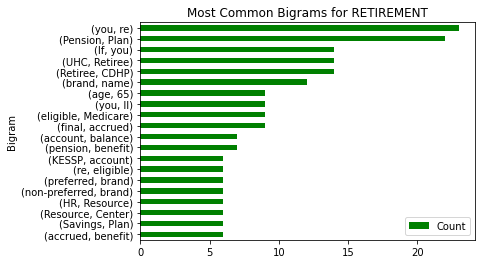

In [52]:
bigrams1 = df_retire['bigrams'].tolist()
bigrams1 = list(chain(*bigrams1))
bigram_counts1 = Counter(bigrams1)
print(bigram_counts1.most_common(20))

b = bigram_counts1.most_common(20)

bigram_plot1 = pd.DataFrame(b, columns =['Bigram', 'Count'])
bigram_plot1 = bigram_plot1.sort_values(by = 'Count')

bigram_plot1.plot(x = 'Bigram',y=['Count'], kind='barh', color='green')
plt.title("Most Common Bigrams for RETIREMENT")
plt.show()

#### Save Tile Bi-grams

In [53]:
bigrams2 = df_savings['bigrams'].tolist()
bigrams2 = list(chain(*bigrams2))
bigram_counts2 = Counter(bigrams2)
print(bigram_counts2.most_common(20))

c = bigram_counts2.most_common(20)

bigram_plot2 = pd.DataFrame(c, columns =['Bigram', 'Count'])
bigram_plot2 = bigram_plot2.sort_values(by = 'Count')

bigram_plot2.plot(x = 'Bigram',y=['Count'], kind='barh', color='orange')
plt.title("Most Common Bigrams for SAVINGS")
plt.show()

[(('healthcare', 'expenses'), 16), (('Health', 'Care'), 15), (('HC', 'FSA'), 14), (('medical', 'plan'), 11), (('use', 'money'), 9), (('Care', 'FSA'), 9), (('eligible', 'healthcare'), 9), (('Express', 'Scripts'), 9), (('eligible', 'refunds'), 8), (('Care', 'Flexible'), 7), (('Flexible', 'Spending'), 7), (('Spending', 'Account'), 7), (('HealthEquity', 'WageWorks'), 7), (('MSK', 'medical'), 7), (('I', 'use'), 7), (('Health', 'Savings'), 7), (('Savings', 'Account'), 7), (('Account', 'HSA'), 7), (('3', '600'), 7), (('7', '200'), 7)]


#### New Hire Tile Bi-grams

[(('Open', 'Enrollment'), 37), (('medical', 'plan'), 11), (('ID', 'cards'), 9), (('ID', 'card'), 8), (('HC', 'FSA'), 7), (('Workday', 'Inbox'), 6), (('change', 'status'), 6), (('Care', 'Flexible'), 6), (('Flexible', 'Spending'), 6), (('November', '6'), 6), (('Health', 'Care'), 5), (('2021', 'benefits'), 5), (('Dependent', 'Care'), 5), (('MSK', 'medical'), 5), (('covered', 'dependents'), 5), (('initial', 'Open'), 4), (('Enrollment', 'event'), 4), (('medical', 'plans'), 4), (('enroll', 'HSA'), 4), (('Spending', 'Account'), 4)]


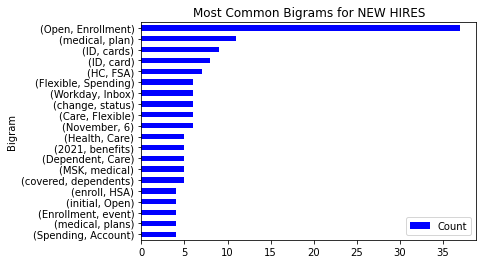

In [54]:
bigrams3 = df_new_hire['bigrams'].tolist()
bigrams3 = list(chain(*bigrams3))
bigram_counts3 = Counter(bigrams3)
print(bigram_counts3.most_common(20))

d = bigram_counts3.most_common(20)

bigram_plot3 = pd.DataFrame(d, columns =['Bigram', 'Count'])
bigram_plot3 = bigram_plot3.sort_values(by = 'Count')

bigram_plot3.plot(x = 'Bigram',y=['Count'], kind='barh', color='blue')
plt.title("Most Common Bigrams for NEW HIRES")
plt.show()

#### Change Tile Bi-grams

In [55]:
bigrams4 = df_change['bigrams'].tolist()
bigrams4 = list(chain(*bigrams4))
bigram_counts4 = Counter(bigrams4)
print(bigram_counts4.most_common(20))

e = bigram_counts4.most_common(20)

bigram_plot4 = pd.DataFrame(e, columns =['Bigram', 'Count'])
bigram_plot4 = bigram_plot4.sort_values(by = 'Count')

bigram_plot3.plot(x = 'Bigram',y=['Count'], kind='barh', color='purple')
plt.title("Most Common Bigrams for CHANGE")
plt.show()

[(('change', 'status'), 13), (('status', 'event'), 13), (('domestic', 'partner'), 7), (('Open', 'Enrollment'), 6), (('coverage', 'effective'), 6), (('event', 'For'), 5), (('within', '31'), 4), (('31', 'days'), 4), (('days', 'event'), 4), (('make', 'changes'), 4), (('event', 'April'), 4), (('April', '1'), 4), (('make', 'change'), 3), (('change', 'benefits'), 3), (('experience', 'change'), 3), (('For', 'guidance'), 3), (('guidance', 'process'), 3), (('process', 'review'), 3), (('review', 'Change'), 3), (('Change', 'Your'), 3)]


#### Get Active Tile Bi-grams

[(('MSK', 'medical'), 12), (('medical', 'plan'), 9), (('Health', 'Advocate'), 8), (('you', 're'), 7), (('enrolled', 'MSK'), 6), (('If', 'you'), 6), (('Well', 'Tip'), 5), (('free', 'confidential'), 4), (('24', '7'), 4), (('re', 'looking'), 3), (('confidential', 'counseling'), 3), (('loved', 'ones'), 3), (('Medical', 'Plan'), 3), (('PM', 'ET'), 3), (('mental', 'health'), 3), (('get', 'started'), 3), (('covered', 'dependents'), 3), (('Employee', 'Health'), 3), (('Well', 'Work'), 3), (('emotional', 'health'), 2)]


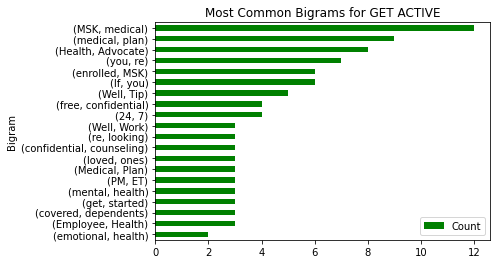

In [56]:
bigrams5 = df_get_active['bigrams'].tolist()
bigrams5 = list(chain(*bigrams5))
bigram_counts5 = Counter(bigrams5)
print(bigram_counts5.most_common(20))

f = bigram_counts5.most_common(20)

bigram_plot5 = pd.DataFrame(f, columns =['Bigram', 'Count'])
bigram_plot5 = bigram_plot5.sort_values(by = 'Count')

bigram_plot5.plot(x = 'Bigram',y=['Count'], kind='barh', color='green')
plt.title("Most Common Bigrams for GET ACTIVE")
plt.show()

#### Take Leave Tile Bi-grams

[(('sick', 'time'), 21), (('Long-Term', 'Disability'), 13), (('you', 're'), 10), (('waiting', 'period'), 10), (('LTD', 'benefits'), 9), (('calendar', 'days'), 8), (('Short-Term', 'Disability'), 8), (('legacy', 'sick'), 8), (('return', 'work'), 7), (('seven', 'calendar'), 7), (('hours', 'per'), 7), (('per', 'week'), 7), (('New', 'York'), 7), (('sick', 'bank'), 7), (('STD', 'benefits'), 7), (('LTD', 'coverage'), 7), (('contact', 'MetLife'), 6), (('you', 'll'), 6), (('ll', 'receive'), 6), (('exempt', 'salaried'), 6)]


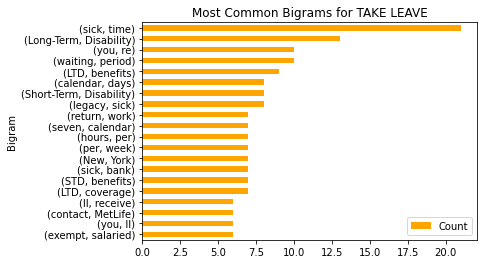

In [57]:
bigrams6 = df_take_leave['bigrams'].tolist()
bigrams6 = list(chain(*bigrams6))
bigram_counts6 = Counter(bigrams6)
print(bigram_counts6.most_common(20))

g = bigram_counts6.most_common(20)

bigram_plot6 = pd.DataFrame(g, columns =['Bigram', 'Count'])
bigram_plot6 = bigram_plot6.sort_values(by = 'Count')

bigram_plot6.plot(x = 'Bigram',y=['Count'], kind='barh', color='orange')
plt.title("Most Common Bigrams for TAKE LEAVE")
plt.show()

#### Cancer Tile Bi-grams

[(('family', 'member'), 3), (('MSK', 'family'), 3), (('MSK', 'Direct'), 3), (('member', 'diagnosed'), 2), (('diagnosed', 'cancer'), 2), (('cancer', 'think'), 2), (('think', 'may'), 2), (('may', 'facing'), 2), (('facing', 'cancer'), 2), (('cancer', 'diagnosis'), 2), (('diagnosis', 'you'), 2), (('you', 're'), 2), (('care', 'MSK'), 2), (('844', 'MSK-4MSK'), 2), (('MSK-4MSK', '844'), 2), (('844', '675-4675'), 2), (('MSK', 'Cancer'), 2), (('Leave', 'Absence'), 2), (('need', 'take'), 2), (('You', 'also'), 2)]


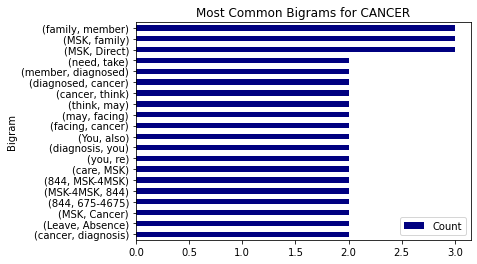

In [58]:
bigrams7 = df_cancer['bigrams'].tolist()
bigrams7 = list(chain(*bigrams7))
bigram_counts7 = Counter(bigrams7)
print(bigram_counts7.most_common(20))

h = bigram_counts7.most_common(20)

bigram_plot7 = pd.DataFrame(h, columns =['Bigram', 'Count'])
bigram_plot7 = bigram_plot7.sort_values(by = 'Count')

bigram_plot7.plot(x = 'Bigram',y=['Count'], kind='barh', color='navy')
plt.title("Most Common Bigrams for CANCER")
plt.show()

#### Child Tile Bi-grams

[(('you', 'll'), 5), (('31', 'days'), 4), (('change', 'status'), 3), (('leave', 'absence'), 3), (('federal', 'state'), 3), (('ll', 'need'), 3), (('within', '31'), 3), (('leave', 'options'), 2), (('healthcare', 'providers'), 2), (('new', 'child'), 2), (('coordinate', 'leave'), 2), (('qualify', 'for'), 2), (('you', 're'), 2), (('833', '622-0138'), 2), (('Navigating', 'Leave'), 2), (('Leave', 'page'), 2), (('and', 'nbsp'), 2), (('Open', 'Enrollment'), 2), (('The', 'Spot'), 2), (('make', 'changes'), 2)]


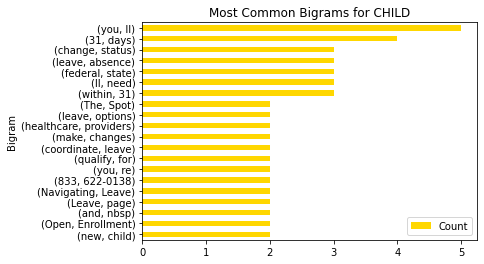

In [59]:
bigrams8 = df_child['bigrams'].tolist()
bigrams8 = list(chain(*bigrams8))
bigram_counts8 = Counter(bigrams8)
print(bigram_counts8.most_common(20))

i = bigram_counts8.most_common(20)

bigram_plot8 = pd.DataFrame(i, columns =['Bigram', 'Count'])
bigram_plot8 = bigram_plot8.sort_values(by = 'Count')

bigram_plot8.plot(x = 'Bigram',y=['Count'], kind='barh', color='gold')
plt.title("Most Common Bigrams for CHILD")
plt.show()

#### Child Care Tile Bi-grams

[(('child', 'care'), 11), (('Bright', 'Horizons'), 6), (('you', 're'), 4), (('New', 'York'), 4), (('Take', 'advantage'), 3), (('York', 'City'), 3), (('Work', 'Life'), 3), (('right', 'child'), 2), (('MSK', 'offers'), 2), (('care', 'options'), 2), (('care', 'services'), 2), (('service', 'You'), 2), (('re', 'looking'), 2), (('you', 'll'), 2), (('ll', 'need'), 2), (('employee', 'ID'), 2), (('ID', 'number'), 2), (('Horizons', 'Additional'), 2), (('Additional', 'Family'), 2), (('Family', 'Support'), 2)]


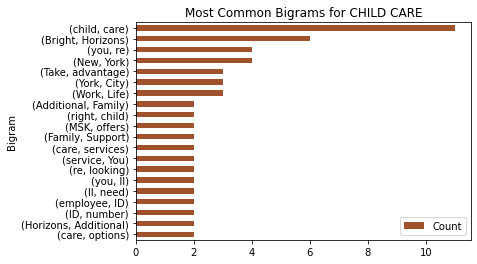

In [60]:
bigrams9 = df_c_care['bigrams'].tolist()
bigrams9 = list(chain(*bigrams9))
bigram_counts9 = Counter(bigrams9)
print(bigram_counts9.most_common(20))

j = bigram_counts9.most_common(20)

bigram_plot9 = pd.DataFrame(j, columns =['Bigram', 'Count'])
bigram_plot9 = bigram_plot9.sort_values(by = 'Count')

bigram_plot9.plot(x = 'Bigram',y=['Count'], kind='barh', color='sienna')
plt.title("Most Common Bigrams for CHILD CARE")
plt.show()

[Back to top](#top)

<a id="trigrams"></a>
### Tri-grams

### Run the tri-gram function on the new text column for each dataframe created above

In [61]:
df_health['trigrams'] = df_health.apply(lambda row: _trigram(row['tokenized']), axis=1)
df_savings['trigrams'] = df_savings.apply(lambda row: _trigram(row['tokenized']), axis=1)
df_retire['trigrams'] = df_retire.apply(lambda row: _trigram(row['tokenized']), axis=1) 
df_new_hire['trigrams'] = df_new_hire.apply(lambda row: _trigram(row['tokenized']), axis=1)

df_change['trigrams'] = df_change.apply(lambda row: _trigram(row['tokenized']), axis=1) 
df_get_active['trigrams'] = df_get_active.apply(lambda row: _trigram(row['tokenized']), axis=1) 
df_take_leave['trigrams'] = df_take_leave.apply(lambda row: _trigram(row['tokenized']), axis=1) 

df_cancer['trigrams'] = df_cancer.apply(lambda row: _trigram(row['tokenized']), axis=1) 
df_child['trigrams'] = df_child.apply(lambda row: _trigram(row['tokenized']), axis=1) 
df_c_care['trigrams'] = df_c_care.apply(lambda row: _trigram(row['tokenized']), axis=1) 

#### Health Tile Tri-grams

[(('Rx', 'Savings', 'Solutions'), 25), (('MSK', 'medical', 'plan'), 20), (('medical', 'plan', 'options'), 12), (('Health', 'Care', 'FSA'), 12), (('Check', 'Your', 'Providers'), 10), (('All', 'employees', 'covered'), 10), (('employees', 'covered', 'dependents'), 10), (('covered', 'dependents', 'enrolled'), 10), (('dependents', 'enrolled', 'MSK'), 10), (('enrolled', 'MSK', 'medical'), 10), (('medical', 'plan', 'access'), 10), (('preventive', 'care', 'covered'), 9), (('Medical', 'Plan', 'Overview'), 9), (('check', 'the', 'nbsp'), 8), (('the', 'nbsp', 'Medical'), 8), (('nbsp', 'Medical', 'Plan'), 8), (('5-Minute', 'Medical', 'Plan'), 8), (('Medical', 'Plan', 'Modeler'), 8), (('you', 'll', 'pay'), 8), (('Your', 'Providers', 'Find'), 8)]


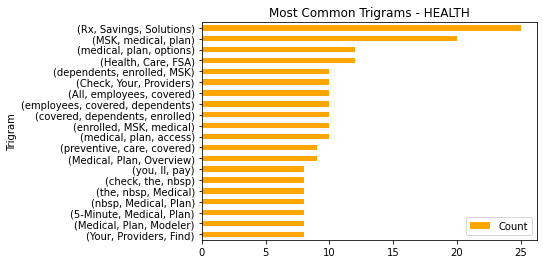

In [62]:
trigrams = df_health['trigrams'].tolist()
trigrams = list(chain(*trigrams))

trigram_counts = Counter(trigrams)
print(trigram_counts.most_common(20))

r = trigram_counts.most_common(20)

trigram_plot = pd.DataFrame(r, columns =['Trigram', 'Count'])
trigram_plot = trigram_plot.sort_values(by = 'Count')

trigram_plot.plot(x = 'Trigram',y=['Count'], kind='barh', color=['orange'])
plt.title("Most Common Trigrams - HEALTH")
plt.show()

#### Retire Tile Tri-grams

[(('If', 'you', 're'), 14), (('UHC', 'Retiree', 'CDHP'), 13), (('you', 're', 'eligible'), 6), (('preferred', 'brand', 'name'), 6), (('non-preferred', 'brand', 'name'), 6), (('HR', 'Resource', 'Center'), 6), (('final', 'accrued', 'benefit'), 6), (('Retirement', 'Savings', 'Plan'), 5), (('December', '19', '2020'), 5), (('Summary', 'Plan', 'Description'), 5), (('December', '1', '2009'), 5), (('become', 'eligible', 'Medicare'), 4), (('Retiree', 'Reimbursement', 'Account'), 4), (('Reimbursement', 'Account', 'RRA'), 4), (('generic', '87', '50'), 4), (('87', '50', 'preferred'), 4), (('50', 'preferred', 'brand'), 4), (('brand', 'name', '150'), 4), (('name', '150', 'non-preferred'), 4), (('150', 'non-preferred', 'brand'), 4)]


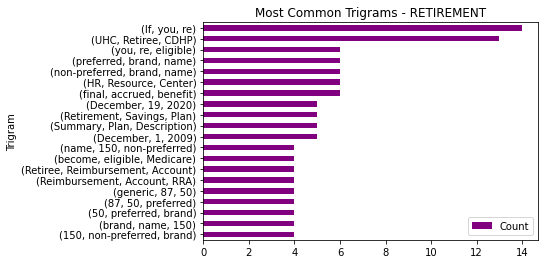

In [63]:
trigrams1 = df_retire['trigrams'].tolist()
trigrams1 = list(chain(*trigrams1))

trigram_counts1 = Counter(trigrams1)
print(trigram_counts1.most_common(20))

s = trigram_counts1.most_common(20)

trigram_plot1 = pd.DataFrame(s, columns =['Trigram', 'Count'])
trigram_plot1 = trigram_plot1.sort_values(by = 'Count')

trigram_plot1.plot(x = 'Trigram',y=['Count'], kind='barh', color=['purple'])
plt.title("Most Common Trigrams - RETIREMENT")
plt.show()

#### Save Tile Tri-grams

[(('Health', 'Care', 'FSA'), 9), (('eligible', 'healthcare', 'expenses'), 9), (('Care', 'Flexible', 'Spending'), 7), (('Flexible', 'Spending', 'Account'), 7), (('Health', 'Savings', 'Account'), 7), (('Savings', 'Account', 'HSA'), 7), (('Health', 'Care', 'Flexible'), 6), (('Spending', 'Account', 'FSA'), 6), (('MSK', 'medical', 'plan'), 6), (('I', 'use', 'money'), 6), (('HSA', 'Health', 'Care'), 6), (('Contribution', 'Your', 'Contribution'), 6), (('Rx', 'Savings', 'Solutions'), 6), (('enrolled', 'MSK', 'medical'), 5), (('drugs', 'without', 'prescription'), 4), (('January', '1', '2020'), 4), (('HSA', 'HC', 'FSA'), 4), (('healthcare', 'expenses', 'However'), 4), (('MSK', 'Contribution', 'Your'), 4), (('Note', 'Pre-tax', 'deductions'), 4)]


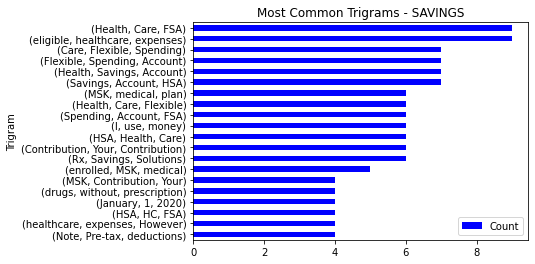

In [64]:
trigrams2 = df_savings['trigrams'].tolist()
trigrams2 = list(chain(*trigrams2))

trigram_counts2 = Counter(trigrams2)
print(trigram_counts2.most_common(20))

t = trigram_counts2.most_common(20)

trigram_plot2 = pd.DataFrame(t, columns =['Trigram', 'Count'])
trigram_plot2 = trigram_plot2.sort_values(by = 'Count')

trigram_plot2.plot(x = 'Trigram',y=['Count'], kind='barh', color=['blue'])
plt.title("Most Common Trigrams - SAVINGS")
plt.show()

#### New Hire Tile Tri-grams

[(('Rx', 'Savings', 'Solutions'), 25), (('MSK', 'medical', 'plan'), 20), (('medical', 'plan', 'options'), 12), (('Health', 'Care', 'FSA'), 12), (('Check', 'Your', 'Providers'), 10), (('All', 'employees', 'covered'), 10), (('employees', 'covered', 'dependents'), 10), (('covered', 'dependents', 'enrolled'), 10), (('dependents', 'enrolled', 'MSK'), 10), (('enrolled', 'MSK', 'medical'), 10), (('medical', 'plan', 'access'), 10), (('preventive', 'care', 'covered'), 9), (('Medical', 'Plan', 'Overview'), 9), (('check', 'the', 'nbsp'), 8), (('the', 'nbsp', 'Medical'), 8), (('nbsp', 'Medical', 'Plan'), 8), (('5-Minute', 'Medical', 'Plan'), 8), (('Medical', 'Plan', 'Modeler'), 8), (('you', 'll', 'pay'), 8), (('Your', 'Providers', 'Find'), 8)]


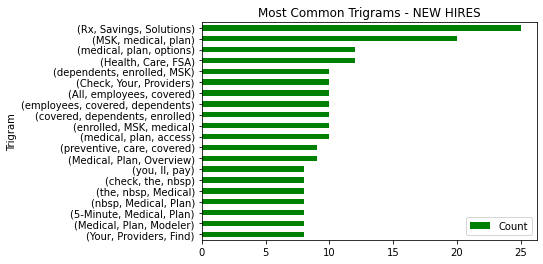

In [65]:
trigrams3 = df_health['trigrams'].tolist()
trigrams3 = list(chain(*trigrams3))

trigram_counts3 = Counter(trigrams3)
print(trigram_counts3.most_common(20))

u = trigram_counts3.most_common(20)

trigram_plot3 = pd.DataFrame(u, columns =['Trigram', 'Count'])
trigram_plot3 = trigram_plot3.sort_values(by = 'Count')

trigram_plot3.plot(x = 'Trigram',y=['Count'], kind='barh', color=['green'])
plt.title("Most Common Trigrams - NEW HIRES")
plt.show()

#### Change Tile Tri-grams

[(('change', 'status', 'event'), 13), (('within', '31', 'days'), 4), (('31', 'days', 'event'), 4), (('status', 'event', 'April'), 4), (('make', 'change', 'benefits'), 3), (('experience', 'change', 'status'), 3), (('For', 'guidance', 'process'), 3), (('guidance', 'process', 'review'), 3), (('process', 'review', 'Change'), 3), (('review', 'Change', 'Your'), 3), (('Change', 'Your', 'Benefits'), 3), (('Your', 'Benefits', 'Outside'), 3), (('Benefits', 'Outside', 'Open'), 3), (('Outside', 'Open', 'Enrollment'), 3), (('Open', 'Enrollment', 'Change'), 3), (('Enrollment', 'Change', 'Status'), 3), (('Change', 'Status', 'Life'), 3), (('Status', 'Life', 'Event'), 3), (('Life', 'Event', 'instructions'), 3), (('Event', 'instructions', 'The'), 3)]


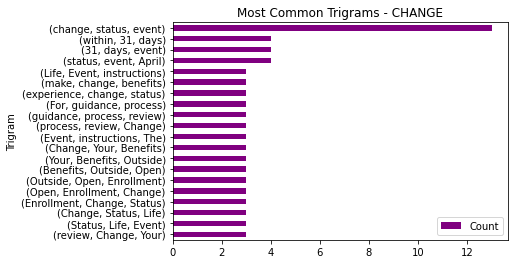

In [66]:
trigrams4 = df_change['trigrams'].tolist()
trigrams4 = list(chain(*trigrams4))

trigram_counts4 = Counter(trigrams4)
print(trigram_counts4.most_common(20))

v = trigram_counts4.most_common(20)

trigram_plot4 = pd.DataFrame(v, columns =['Trigram', 'Count'])
trigram_plot4 = trigram_plot4.sort_values(by = 'Count')

trigram_plot4.plot(x = 'Trigram',y=['Count'], kind='barh', color=['purple'])
plt.title("Most Common Trigrams - CHANGE")
plt.show()


#### Get Active Tile Tri-grams

[(('MSK', 'medical', 'plan'), 9), (('enrolled', 'MSK', 'medical'), 6), (('If', 'you', 're'), 6), (('you', 're', 'looking'), 3), (('You', 'required', 'enrolled'), 2), (('required', 'enrolled', 'MSK'), 2), (('medical', 'plan', 'must'), 2), (('plan', 'must', 'be'), 2), (('must', 'be', 'nbsp'), 2), (('be', 'nbsp', 'eligible'), 2), (('nbsp', 'eligible', 'nbsp'), 2), (('eligible', 'nbsp', 'for'), 2), (('nbsp', 'for', 'MSK'), 2), (('for', 'MSK', 'medical'), 2), (('MSK', 'medical', 'coverage'), 2), (('medical', 'coverage', 'use'), 2), (('coverage', 'use', 'Magellan'), 2), (('use', 'Magellan', 's'), 2), (('Magellan', 's', 'services'), 2), (('MSK', 'login', 'required'), 2)]


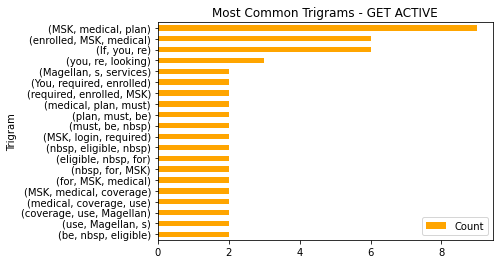

In [67]:
trigrams5 = df_get_active['trigrams'].tolist()
trigrams5 = list(chain(*trigrams5))

trigram_counts5 = Counter(trigrams5)
print(trigram_counts5.most_common(20))

w = trigram_counts5.most_common(20)

trigram_plot5 = pd.DataFrame(w, columns =['Trigram', 'Count'])
trigram_plot5 = trigram_plot5.sort_values(by = 'Count')

trigram_plot5.plot(x = 'Trigram',y=['Count'], kind='barh', color=['orange'])
plt.title("Most Common Trigrams - GET ACTIVE")
plt.show()

#### Take Leave Tile Tri-grams

In [68]:
trigrams6 = df_take_leave['trigrams'].tolist()
trigrams6 = list(chain(*trigrams6))

trigram_counts6 = Counter(trigrams6)
print(trigram_counts6.most_common(20))

x = trigram_counts6.most_common(20)

trigram_plot6 = pd.DataFrame(x, columns =['Trigram', 'Count'])
trigram_plot6 = trigram_plot6.sort_values(by = 'Count')

trigram_plot6.plot(x = 'Trigram',y=['Count'], kind='barh', color=['green'])
plt.title("Most Common Trigrams - TAKE LEAVE")
plt.show()

[(('seven', 'calendar', 'days'), 7), (('legacy', 'sick', 'bank'), 7), (('20', 'hours', 'per'), 6), (('hours', 'per', 'week'), 6), (('annual', 'sick', 'time'), 6), (('If', 'you', 're'), 5), (('you', 'll', 'receive'), 5), (('HR', 'Resource', 'Center'), 5), (('Paid', 'Parental', 'Leave'), 5), (('you', 're', 'unable'), 4), (('due', 'illness', 'injury'), 4), (('use', 'sick', 'time'), 4), (('December', '31', '2020'), 4), (('MSK', 'Paid', 'Parental'), 4), (('per', 'week', 'eligible'), 4), (('Want', 'Know', 'More'), 4), (('Navigating', 'Leave', 'page'), 4), (('Short-Term', 'Disability', 'STD'), 4), (('Documents', 'amp', 'Forms'), 4), (('Core', 'LTD', 'coverage'), 4)]


#### Cancer Tile Tri-grams

In [69]:
trigrams7 = df_cancer['trigrams'].tolist()
trigrams7 = list(chain(*trigrams7))

trigram_counts7 = Counter(trigrams7)
print(trigram_counts7.most_common(20))

y = trigram_counts7.most_common(20)

trigram_plot7 = pd.DataFrame(y, columns =['Trigram', 'Count'])
trigram_plot7 = trigram_plot7.sort_values(by = 'Count')

trigram_plot7.plot(x = 'Trigram',y=['Count'], kind='barh', color=['cornflowerblue'])
plt.title("Most Common Trigrams - CANCER")
plt.show()

[(('family', 'member', 'diagnosed'), 2), (('member', 'diagnosed', 'cancer'), 2), (('diagnosed', 'cancer', 'think'), 2), (('cancer', 'think', 'may'), 2), (('think', 'may', 'facing'), 2), (('may', 'facing', 'cancer'), 2), (('facing', 'cancer', 'diagnosis'), 2), (('cancer', 'diagnosis', 'you'), 2), (('diagnosis', 'you', 're'), 2), (('844', 'MSK-4MSK', '844'), 2), (('MSK-4MSK', '844', '675-4675'), 2), (("'", 'Facing', 'cancer'), 1), (('Facing', 'cancer', 'together'), 1), (('cancer', 'together', 'If'), 1), (('together', 'If', 'family'), 1), (('If', 'family', 'member'), 1), (('you', 're', 'alone'), 1), (('re', 'alone', 'The'), 1), (('alone', 'The', 'Basics'), 1), (('The', 'Basics', 'We'), 1)]


#### Child Tile Tri-grams

In [70]:
trigrams8 = df_child['trigrams'].tolist()
trigrams8 = list(chain(*trigrams8))

trigram_counts8 = Counter(trigrams8)
print(trigram_counts8.most_common(20))

z = trigram_counts8.most_common(20)

trigram_plot8 = pd.DataFrame(z, columns =['Trigram', 'Count'])
trigram_plot8 = trigram_plot8.sort_values(by = 'Count')

trigram_plot8.plot(x = 'Trigram',y=['Count'], kind='barh', color=['wheat'])
plt.title("Most Common Trigrams - CHILD")
plt.show()

[(('within', '31', 'days'), 3), (('coordinate', 'leave', 'absence'), 2), (('you', 'll', 'need'), 2), (('Navigating', 'Leave', 'page'), 2), (('make', 'changes', 'benefits'), 2), (('federally', 'declared', 'national'), 2), (('declared', 'national', 'emergency'), 2), (('change', 'status', 'event'), 2), (('enroll', 'Dependent', 'Care'), 2), (('Dependent', 'Care', 'FSA'), 2), (('requires', 'MSK', 'login'), 2), (('long', 'notification', 'received'), 2), (('notification', 'received', 'within'), 2), (('received', 'within', '31'), 2), (('HR', 'Resource', 'Center'), 2), (('hrrc', 'mskcc', 'org'), 2), (("'", 'Welcoming', 'new'), 1), (('Welcoming', 'new', 'addition'), 1), (('new', 'addition', 'Congratulations'), 1), (('addition', 'Congratulations', 'This'), 1)]


#### Child Care Tile Tri-grams

In [71]:
trigrams9 = df_c_care['trigrams'].tolist()
trigrams9 = list(chain(*trigrams9))

trigram_counts9 = Counter(trigrams9)
print(trigram_counts9.most_common(20))

x = trigram_counts9.most_common(20)

trigram_plot9 = pd.DataFrame(x, columns =['Trigram', 'Count'])
trigram_plot9 = trigram_plot9.sort_values(by = 'Count')

trigram_plot9.plot(x = 'Trigram',y=['Count'], kind='barh', color=['coral'])
plt.title("Most Common Trigrams - CHILD CARE")
plt.show()

[(('New', 'York', 'City'), 3), (('right', 'child', 'care'), 2), (('you', 're', 'looking'), 2), (('you', 'll', 'need'), 2), (('employee', 'ID', 'number'), 2), (('Bright', 'Horizons', 'Additional'), 2), (('Horizons', 'Additional', 'Family'), 2), (('Additional', 'Family', 'Support'), 2), (('Family', 'Support', 'Program'), 2), (('If', 'you', 're'), 2), (("'", 'Looking', 'child'), 1), (('Looking', 'child', 'care'), 1), (('child', 'care', 'Finding'), 1), (('care', 'Finding', 'right'), 1), (('Finding', 'right', 'child'), 1), (('child', 'care', 'providers'), 1), (('care', 'providers', 'challenge'), 1), (('providers', 'challenge', 'MSK'), 1), (('challenge', 'MSK', 'offers'), 1), (('MSK', 'offers', 'benefits'), 1)]


[Back to top](#top)

<a id="keywords"></a>
### Extract Keywords from MSK URL Paths

Earlier in this notebook, URL paths from MSK-provided data were mapped to a tile on the MSK Benefits website. Below, a regex pattern is constructed to find the word "/keyword/" and all text after "keyword" until the next forward slash "/".

### Regex pattern to find "/keyword/"

In [72]:
find_kw = re.compile(r'^\/keyword\/(.*)\/')

### Function to extract keywords from URL Paths

In [73]:
url_kws = []

def _url_keywords(y):
    
    for i in y:
        
        if '/keyword/' in i: 
            words = find_kw.search(i)
            words_clean = words.group(1).replace("-", ' ')
            url_kws.append(words_clean)
            
    print(url_kws)  

### Print keywords for tiles

Print statements are commented out to avoid lengthy output

In [74]:
#print(_url_keywords(health))
#print(_url_keywords(savings))
#print(_url_keywords(new_hire))
#print(_url_keywords(change))
#print(_url_keywords(get_active))
#print(_url_keywords(take_leave))
#print(_url_keywords(cancer))
#print(_url_keywords(child))
#print(_url_keywords(child_care))
#print(_url_keywords(relationship))
#print(_url_keywords(retire))

<a id="data_for_HR"></a>
### Data for HR

This section extracts single words/bi-grams/tri-grams along with their respective count. A function creates a list as output. Each tile list can be used to ensure web pages behind a tile are utilizing high-frequency wording in URL paths.

### Function to create list of words

In [75]:
from itertools import chain
from collections import Counter

def word_counts(text):
    
    _one_word = {}
    _bi_gram = {}
    _tri_gram = {}
    
    text1 = ' '.join(text)
    
    a = text1.split()
    b = Counter(a)
    _one_word.update(b)
    
    c = nltk.bigrams(a)
    e = Counter(c)
    _bi_gram.update(e)
    
    f = nltk.trigrams(a)
    h = Counter(f)
    _tri_gram.update(h)
    
    z = {**_one_word, **_bi_gram, **_tri_gram}
    
    word_df = pd.DataFrame.from_dict(z, orient='index',
                       columns=['Word'])

    
    return word_df
    

### Run each tile dataframe through function; store as unique variable

In [76]:
retire_words = word_counts(df_retire['text_clean2'])
health_words = word_counts(df_health['text_clean2'])
save_words = word_counts(df_savings['text_clean2'])
new_hire_words = word_counts(df_new_hire['text_clean2'])
change_words = word_counts(df_change['text_clean2'])
get_active_words = word_counts(df_get_active['text_clean2'])
take_leave_words = word_counts(df_take_leave['text_clean2'])
cancer_words = word_counts(df_cancer['text_clean2'])
child_words = word_counts(df_child['text_clean2'])
child_care_words = word_counts(df_c_care['text_clean2'])

### View each list of words by tile

Print statements are commented out to reduce lengthy scrolling.

In [77]:
#print(retire_words)
#print(health_words)
#print(save_words)
#print(new_hire_words)
#print(change_words)
#print(get_active_words)
#print(take_leave_words)
#print(cancer_words)
#print(child_words)
#print(child_care_words)

### Save file as data asset in project

To save any of the above lists as a data asset (which can also be downloaded to a local machine), name the file output (ex: "health_all_grams.csv") and indicate which list to save (ex: "health_words") in the code below.

In [76]:
project.save_data("health_all_grams.csv", health_words.to_csv(index=True), overwrite=True)

{'file_name': 'health_all_grams.csv',
 'message': 'File saved to project storage.',
 'asset_id': 'fcd242b2-3aea-4d0b-aaab-51db0c4de6eb'}

[Back to top](#top)